<a href="https://colab.research.google.com/github/VigneshDiv/FII_NX1-NARC_vignesh-divvela/blob/main/Cosmological_Inference_with_Void_Properties_and_Normalizing_Flow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip3 install pyro-ppl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 47.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 38.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [ ]:
!pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 20.6 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
import pyro
import pyro.distributions as dist
import pyro.distributions.transforms as T
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
import h5py
import pandas as pd
import os
import seaborn as sn
from pandas.core.frame import fmt
import optuna

In [ ]:
def loadCondition():
  # input data
  X = []
  for i in range(2000):
    path = "drive/MyDrive/VoidCatalog/Abundance/abundance_z=0.0_" + str(i) + "_HR_linspace_60_5_19bins_untrimmed.csv"
    if not os.path.exists(path):
      continue
    f = pd.read_csv(path)
    X.append(f["densitycontrast"])

  X = np.array(X)
  X = StandardScaler().fit_transform(X)

  return X

In [ ]:
def create_condDist(targe_dimension, context_dimension, n_context_layers, n_conditional_layers):
  dist_base = dist.Normal(torch.zeros(context_dimension), torch.ones(context_dimension))

  context_transforms = []
  for i in range(n_context_layers):
    context_transforms.append(T.spline_autoregressive(context_dimension))
  dist_x1 = dist.TransformedDistribution(dist_base, context_transforms)

  conditional_transforms = []
  dist_base2 = dist.Normal(torch.zeros(targe_dimension), torch.ones(targe_dimension))
  for i in range(n_conditional_layers):
    conditional_transforms.append(T.conditional_spline_autoregressive(targe_dimension, context_dim=context_dimension, bound=5))
  dist_x2_given_x1 = dist.ConditionalTransformedDistribution(dist_base2, conditional_transforms)

  return dist_x1, dist_x2_given_x1, context_transforms, conditional_transforms

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
def loadTarget():
  # output data
  params = []
  f_para = pd.read_csv("drive/MyDrive/VoidCatalog/latin_hypercube_params.txt", sep = " ", header = None)

  for i in range(2000):
    path = "drive/MyDrive/VoidCatalog/Abundance/abundance_z=0.0_" + str(i) + "_HR_linspace_60_5_19bins_untrimmed.csv"
    if not os.path.exists(path):
      continue
    params.append(np.array(f_para)[i])

  params = np.array(params)
  params_Scaler = StandardScaler()
  params = params_Scaler.fit_transform(params)

  return params, params_Scaler

In [ ]:
def createAchi(transforms, lr, fromLoad = False):
  modules = torch.nn.ModuleList(transforms)
  print(modules)
  optimizer = torch.optim.Adam(modules.parameters(), lr=lr)

  if fromLoad:
    print("Loading from existing model...")

  return optimizer

In [ ]:
def prepare_dataSet(input, output):
  X = torch.tensor(input, dtype=torch.float)
  Y = torch.tensor(output, dtype=torch.float)

  training_size = int(input.shape[0]*0.7)
  print(training_size)
  validation_size = int(input.shape[0]*0.15)
  test_size = input.shape[0] - training_size - validation_size

  input_training, input_valid, input_test = torch.utils.data.random_split(X, [training_size, validation_size, test_size], generator=torch.Generator().manual_seed(42))
  output_training, output_valid, output_test = torch.utils.data.random_split(Y, [training_size, validation_size, test_size], generator=torch.Generator().manual_seed(42))

  input_test = torch.stack([d for d in input_test])
  input_valid = torch.stack([d for d in input_valid])
  input_training = torch.stack([d for d in input_training])
  output_test = torch.stack([d for d in output_test])
  output_valid = torch.stack([d for d in output_valid])
  output_training = torch.stack([d for d in output_training])

  return input_training, input_valid, input_test, output_training, output_valid, output_test

In [ ]:
def show_onePostior(input_data, n_simulation, distribution, output_index,scaler = None):
  flow = distribution.condition(input_data[n_simulation]).sample(torch.Size([1000,]))
  if scaler != None:
    flow =  scaler.inverse_transform(flow)
  sns.distplot(flow[:,output_index], hist=False, kde=True,
              bins=None, color='firebrick',
              hist_kws={'edgecolor':'black'},
              kde_kws={'linewidth': 2},
              label='flow')
  plt.grid()

In [ ]:
X = loadCondition()
Y, Y_Scaler = loadTarget()
X.shape, Y.shape

((1985, 18), (1985, 5))

In [ ]:
input_training, input_valid, input_test, output_training, output_valid, output_test = prepare_dataSet(X, Y)
input_test.shape

1389


torch.Size([299, 18])

In [ ]:
output_training.shape

torch.Size([1389, 5])

# Training

In [ ]:
%%time
steps = 200
dist_x1, dist_x2_given_x1 ,x1_transform, x2_transform = create_condDist(5,18,1,5)
transforms = x1_transform + x2_transform
optimizer = createAchi(transforms, 0.00928)

input_training.to(device)
output_training.to(device)

for step in range(steps):
    optimizer.zero_grad()
    ln_p_x1 = dist_x1.log_prob(input_training)
    ln_p_x2_given_x1 = dist_x2_given_x1.condition(input_training.detach()).log_prob(output_training.detach())
    loss = -(ln_p_x1 + ln_p_x2_given_x1).mean()
    loss.backward()
    optimizer.step()
    dist_x1.clear_cache()
    dist_x2_given_x1.clear_cache()

    if step % 10 == 0:
      print('step: {}, loss: {}'.format(step, loss.item()))

ModuleList(
  (0): SplineAutoregressive()
  (1-5): 5 x ConditionalSplineAutoregressive(
    (nn): ConditionalAutoRegressiveNN(
      (layers): ModuleList(
        (0): MaskedLinear(in_features=23, out_features=50, bias=True)
        (1): MaskedLinear(in_features=50, out_features=50, bias=True)
        (2): MaskedLinear(in_features=50, out_features=155, bias=True)
      )
      (f): ReLU()
    )
  )
)
step: 0, loss: 35.6859016418457
step: 10, loss: 26.34341049194336
step: 20, loss: 24.650665283203125
step: 30, loss: 22.682432174682617
step: 40, loss: 21.406137466430664
step: 50, loss: 23.021331787109375
step: 60, loss: 21.638776779174805
step: 70, loss: 20.171419143676758
step: 80, loss: 19.13858985900879
step: 90, loss: 19.3203182220459
step: 100, loss: 18.514421463012695
step: 110, loss: 17.012250900268555
step: 120, loss: 17.298791885375977
step: 130, loss: 16.65241050720215
step: 140, loss: 15.590404510498047
step: 150, loss: 15.857721328735352
step: 160, loss: 15.231550216674805
st

In [ ]:
output_training[1]

tensor([ 0.2520, -0.2292,  0.2405,  1.6859,  0.3981])

<ipython-input-11-3055456760>:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(flow[:,output_index], hist=False, kde=True,


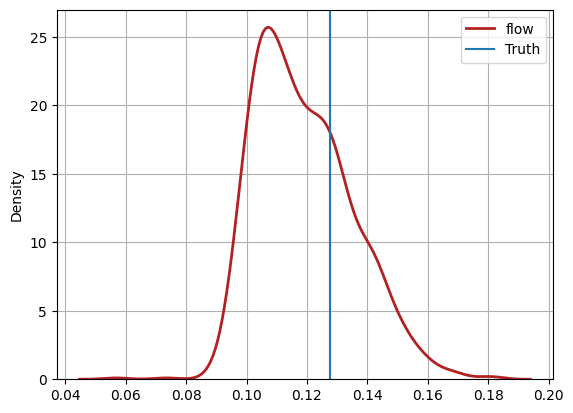

In [ ]:
Dataset_index = 147 # represents different simulation
Parameter_index = 0 # represents different cosmological parameter
show_onePostior(input_training,Dataset_index,dist_x2_given_x1,Parameter_index, Y_Scaler)
plt.axvline(Y_Scaler.inverse_transform(output_training)[Dataset_index,Parameter_index], label = "Truth")
plt.legend()

# Test

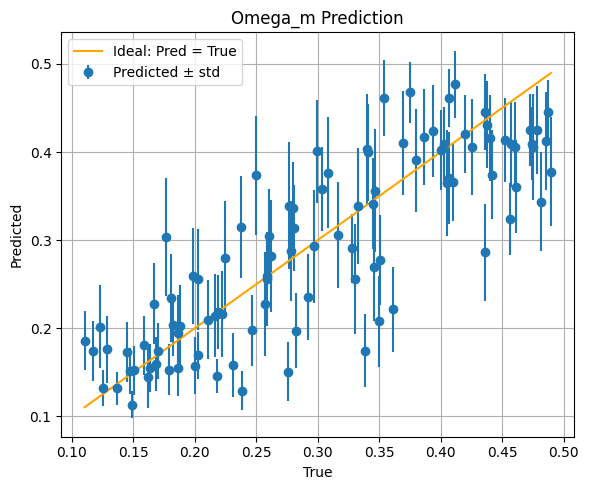

Performance for Omega_m:
  R² Score:    0.6754
  RMSE:        6.3475e-02
  Chi-Squared: 2.1900
  MMRE:        17.7245%
----------------------------------------


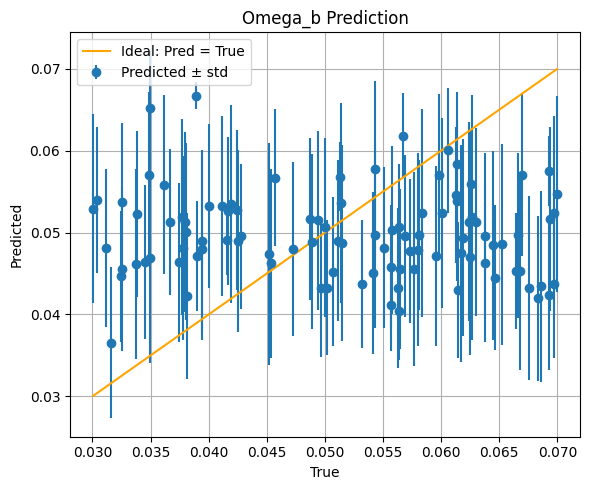

Performance for Omega_b:
  R² Score:    -0.2904
  RMSE:        1.3500e-02
  Chi-Squared: 4.8595
  MMRE:        24.0924%
----------------------------------------


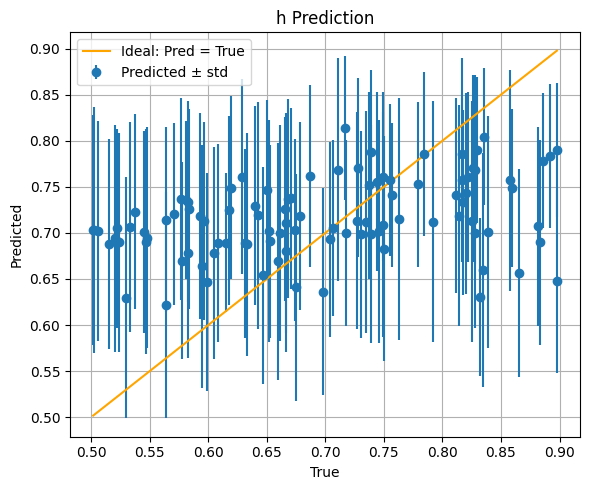

Performance for h:
  R² Score:    0.0934
  RMSE:        1.0666e-01
  Chi-Squared: 1.0066
  MMRE:        13.5845%
----------------------------------------


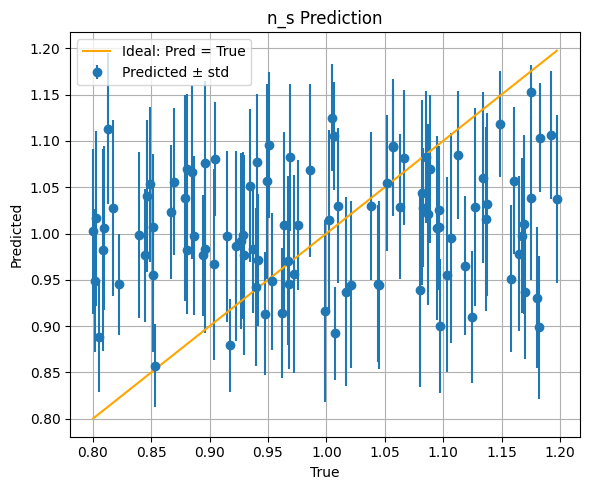

Performance for n_s:
  R² Score:    -0.1472
  RMSE:        1.2566e-01
  Chi-Squared: 2.4550
  MMRE:        10.8315%
----------------------------------------


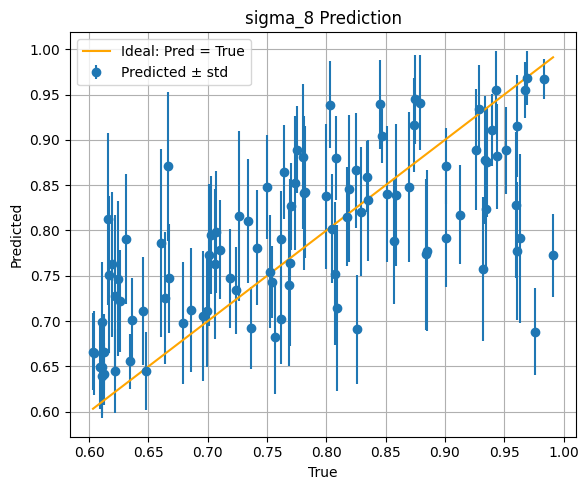

Performance for sigma_8:
  R² Score:    0.4412
  RMSE:        8.7348e-02
  Chi-Squared: 2.0298
  MMRE:        8.9245%
----------------------------------------


In [ ]:
num_params = 5
param_names = ["Omega_m", "Omega_b", "h", "n_s", "sigma_8"]
results = []

input_test = torch.stack([d for d in input_test])
for i in range(input_test.shape[0]):
    flow = dist_x2_given_x1.condition(input_test[i]).sample(torch.Size([1000,]))
    flow = Y_Scaler.inverse_transform(flow)
    # get mean and std for all cosmological parameters
    means_stds = []
    for j in range(num_params):
        means_stds.append(flow[:, j].mean())
        means_stds.append(flow[:, j].std())
    results.append(means_stds)

results = np.array(results)
output_test = torch.stack([d for d in output_test])
output_test_unscaled = Y_Scaler.inverse_transform(output_test)
indexes = np.random.choice(np.arange(results.shape[0]), 100, replace=False)

for i in range(num_params):
    plt.figure(figsize=(6, 5))
    true_vals = output_test_unscaled[indexes, i]
    pred_means = results[indexes, 2 * i]
    pred_stds = results[indexes, 2 * i + 1]

    plt.errorbar(true_vals, pred_means, yerr=pred_stds, fmt='o', label='Predicted ± std')
    plt.plot(np.linspace(true_vals.min(), true_vals.max(), 100),
             np.linspace(true_vals.min(), true_vals.max(), 100),
             color='orange', label='Ideal: Pred = True')

    plt.xlabel("True")
    plt.ylabel("Predicted")
    plt.title(f"{param_names[i]} Prediction")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    from sklearn.metrics import r2_score, mean_squared_error

    r2 = r2_score(true_vals, pred_means)
    rmse = np.sqrt(mean_squared_error(true_vals, pred_means))
    chi_squared = np.mean(((true_vals - pred_means) ** 2) / (pred_stds ** 2))
    mmre = np.mean(np.abs((true_vals - pred_means) / true_vals))

    print(f"Performance for {param_names[i]}:")
    print(f"  R² Score:    {r2:.4f}")
    print(f"  RMSE:        {rmse:.4e}")
    print(f"  Chi-Squared: {chi_squared:.4f}")
    print(f"  MMRE:        {mmre:.4%}")
    print("-" * 40)